### John Franklin Crenshaw

#### The Traveling Salesman Problem

##### Computational Physics final project, Spring 2019

The Traveling Salesman problem asks: "given a list of cities, what is the shortest round trip possible"?

This notebook attempts to solve the Traveling Salesman problem. First, I use an exact solution that checks all of the routes. This is too slow for even modestly sized sets. For solving larger sets, I use simulated annealing and a genetic algorithm. Both are better than the exact solution, but simulated annealing works definitively the best.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from collections.abc import MutableSequence
import operator

from itertools import permutations
from scipy.special import factorial

import time

Ultimate destination of plots is a presentation, so load my custom presentation stylesheet. Also set figure backend to retina for higher resolution

In [2]:
plt.style.use('pres')
%config InlineBackend.figure_format = 'retina'

### "Global" Classes and Functions

In [3]:
class City(complex):
    """Class defines a City object, which inherits from complex.
    Cities have x coord (= real) and y coord (= imag). There is
    also a method which calculates the distance to another city.
    """
    
    @property
    def x(self):
        # define x coord
        return int(self.real)
    
    @property
    def y(self):
        # define y coord
        return int(self.imag)
    
    def dist(self,city):
        # calculate distance to another city
        distance = abs(self - city)
        return distance
    
    def __repr__(self):
        # what the city object looks like
        return "City(" + str(self.x) + "," + str(self.y) + ")"
    
    def __str__(self):
        # what the city object looks like when printed
        return "City(" + str(self.x) + "," + str(self.y) + ")"


In [4]:
def randomCities(N, width=100, seed=None):
    """Generate N cities with random integer x,y locations sampled
    from the range (0,width). The optional parameter seed sets the
    random seed."""
    
    if seed != None:
        random.seed(seed)
         
    cities = []
    for i in range(N):
        x = int(random.random()*width)
        y = int(random.random()*width)
        city = City(x,y)
        cities.append(city)
        
    return cities


This function generates a list of 80 US cities which are used in tests below. The coordinates are adapted from the coordinates found here: https://nbviewer.jupyter.org/url/norvig.com/ipython/TSP.ipynb

In [5]:
def US_cities():
    """Generate list of US cities"""
    x,y = np.genfromtxt("US_cities.txt",unpack=True)
    cities = [City(x[i],y[i]) for i in range(len(x))]
    return cities

In [6]:
class Route(MutableSequence):
    """
    Class that defines a Route object, which inherits from a python
    list. Route objects are just normal list objects, where the 
    elements are the ordered list of cities in the route. 
    
    The class also has 3 methods:
    1. dist() calculates the total distance of the route, including
    returning from the last city to the first.
    2. fitness() is just 1/dist(), which is used for the genetic 
    algorithm
    3. plot() creates a plot of the route using matplotlib
    """
    
    def __init__(self,citylist):
        self.list = citylist

    def __len__(self):
        return len(self.list)
    
    def __getitem__(self,i):
        return self.list[i]
    
    def __delitem__(self,i):
        del self.list[i]
        
    def __setitem__(self,i,val):
        self.list[i] = val
        
    def insert(self,i,val):
        self.list.insert(i,val)
        
    def append(self,val):
        self.list.append(val)
        
    def dist(self):
        # calculate route distance
        ncities = len(self.list)
        dist = 0
        for i in range(ncities):
            city1 = self.list[i-1]
            city2 = self.list[i]
            dist += city1.dist(city2)
        return dist
    
    def fitness(self):
        return 1/self.dist()
    
    def plot(self):
        # plot the route
        x = [city.x for city in self.list]
        y = [city.y for city in self.list]
        fig, ax = plt.subplots(1,1)
        ax.plot(x,y,c='C0')
        ax.plot([x[0],x[-1]],[y[0],y[-1]],c='C0')
        ax.scatter(x,y,c='k',zorder=10)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("dist = {0:.3f}".format(self.dist()))
        return fig,ax
    
    def __repr__(self):
        return str(self.list)
    
    def __str__(self):
        return str(self.list)
    

In [7]:
def randomRoute(cities, seed=None):
    """Generate a random route from a list of cities"""
    
    if seed != None:
        random.seed(seed)
        
    route = random.sample(cities,len(cities))
    route = Route(route)
    return route


In [8]:
def running_min(array):
    """Generates a running minimum of the input array."""
    progress = [array[0]]
    for i in range(1,len(array)):
        if array[i] < progress[-1]:
            progress.append(array[i])
        else:
            progress.append(progress[-1])
    return progress

### Demonstrate classes and functions

In [8]:
# create a city and print its location
city1 = City(2,5)
print("Here is a city object:",city1)
print("city.x =",city1.real)
print("city.y =",city1.imag)

# create a second city and calculate the distance between the two
city2 = City(11,12)
print("Here is a second city:",city2)
print("The distance between my two cities is",city1.dist(city2))

Here is a city object: City(2,5)
city.x = 2.0
city.y = 5.0
Here is a second city: City(11,12)
The distance between my two cities is 11.40175425099138


Here is a random list of 8 cities:
[City(14,36), City(4,20), City(66,21), City(77,73), City(1,86), City(47,2), City(38,37), City(55,58)]
Here is a random route through these cities:
[City(66,21), City(77,73), City(55,58), City(38,37), City(14,36), City(1,86), City(47,2), City(4,20)]


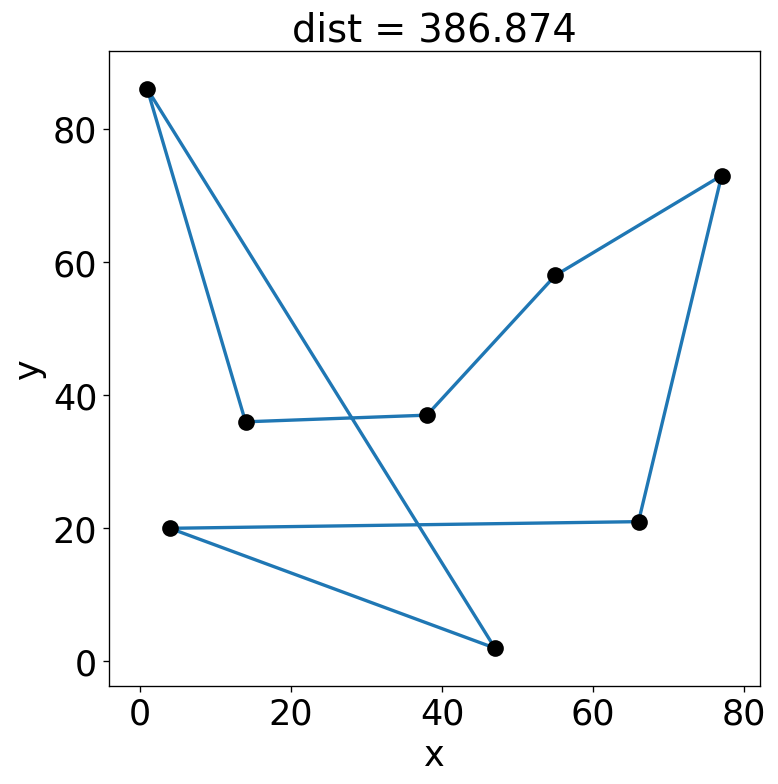

In [9]:
# generate a random list of cities
cities = randomCities(8,seed=274)
print("Here is a random list of 8 cities:\n"+str(cities))

# generate a random route through these cities
route = randomRoute(cities,seed=274)
print("Here is a random route through these cities:\n"+str(route))
route.plot();

### The exact solution

Finding the solution to the traveling salesman problem is trivial! Simply check all of the routes, and return the one with the shortest distance!

This function does just that:

In [9]:
def bestRoute(cities):
    """Return the shortes round-trip route through the given cities."""
    
    # all routes
    routes = [Route(i) for i in list(permutations(cities))]
    # calculate distances
    distances = [route.dist() for route in routes]
    # return shortest route
    imin = np.argmin(distances)
    route = routes[imin]
    return route


Here is the solution for the previously plotted set of cities

Wall time: 396 ms


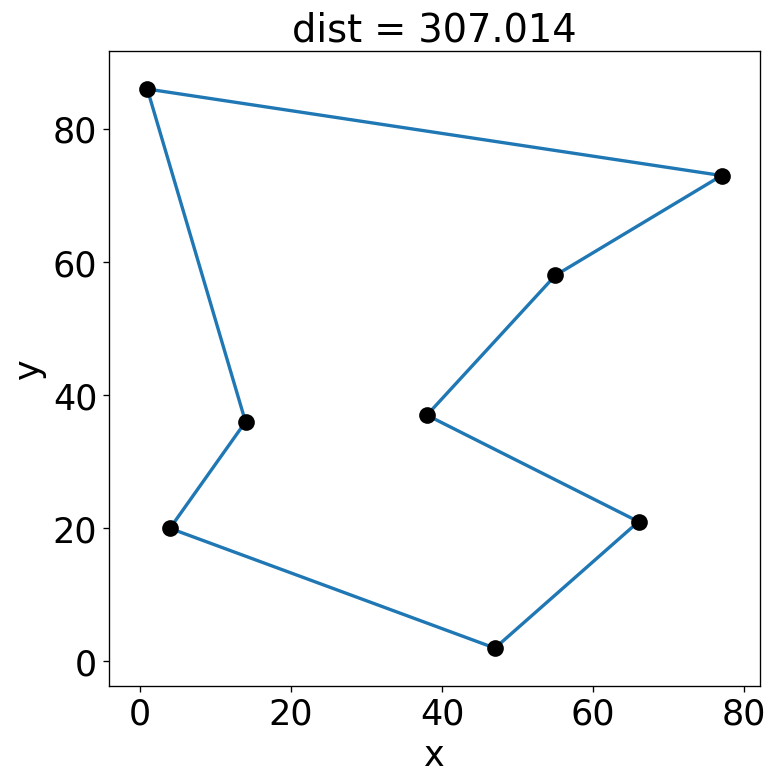

In [11]:
%%time
cities = randomCities(8,seed=274)
route = bestRoute(cities)
route.plot()

Perfect! And it only took 396 ms!

Lets try with 9 cities:

Wall time: 4.12 s


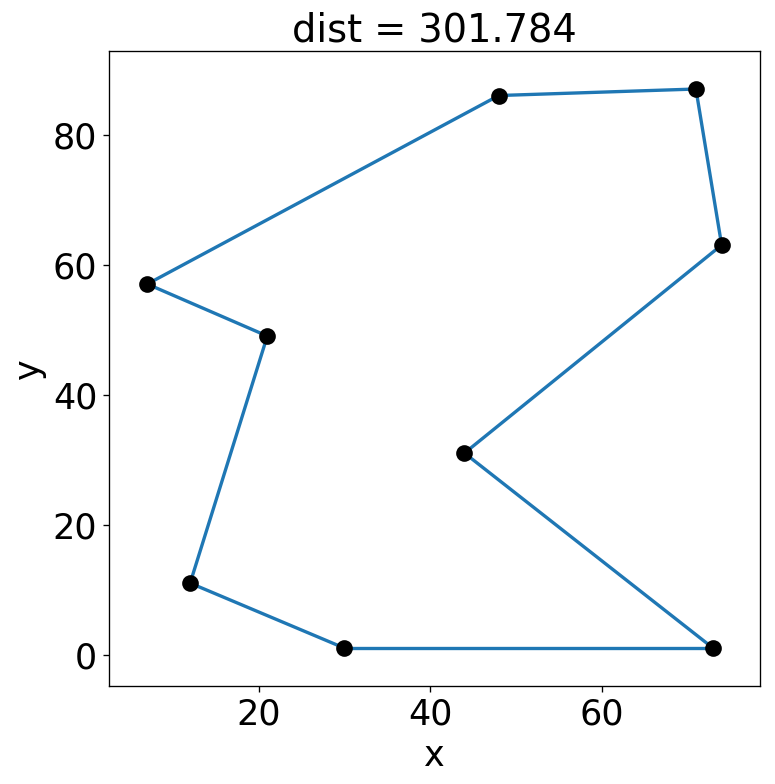

In [12]:
%%time
cities = randomCities(9,seed=444)
route = bestRoute(cities)
route.plot()

We got the result, but this time it took 4.12 s. That's 10x as long for only 1 more city...

Lets try 10 cities:

Wall time: 41.7 s


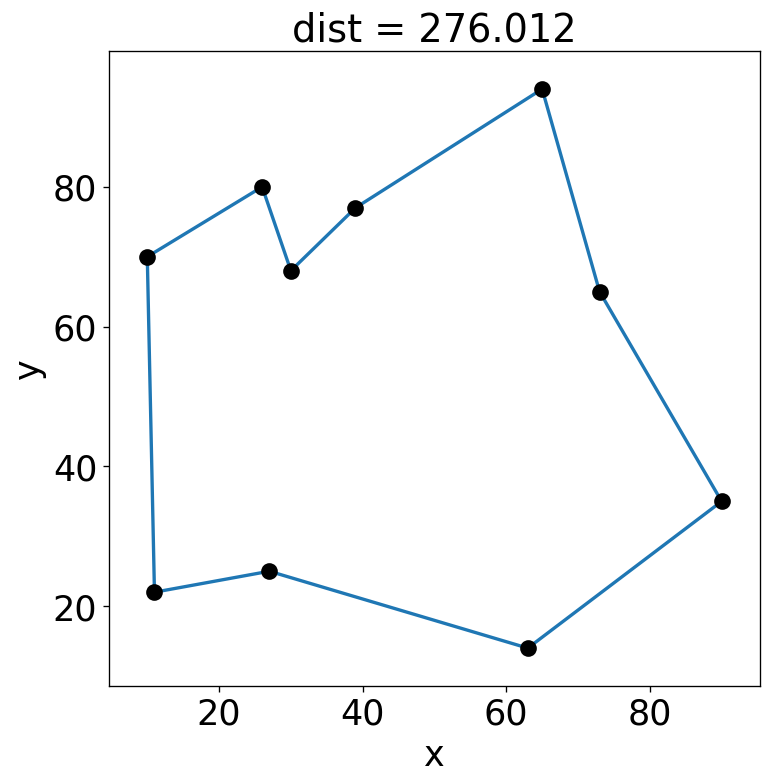

In [77]:
%%time
cities = randomCities(10,seed=14)
route = bestRoute(cities)
route.plot()

Again, the computation time increased by a factor of 10. Obviously this will get computational expensive very quickly. This is because for $N$ cities there are $N!$ routes to check. Factorial growth is faster than exponential, so clearly this method will become infeasible with even modest values of N.

To get an idea of how inefficient this method is, let's plots estimated computational time as a function of N. To estimate my computers speed, we can calculate the number of routes checked per second in the N=10 example:
$$ \text{computational speed} = \frac{10!}{41.7 \text{ s}} \approx 87,000 \text{ s}^{-1} $$
Using this speed, I calculate computation time as a function of N and plot the results:

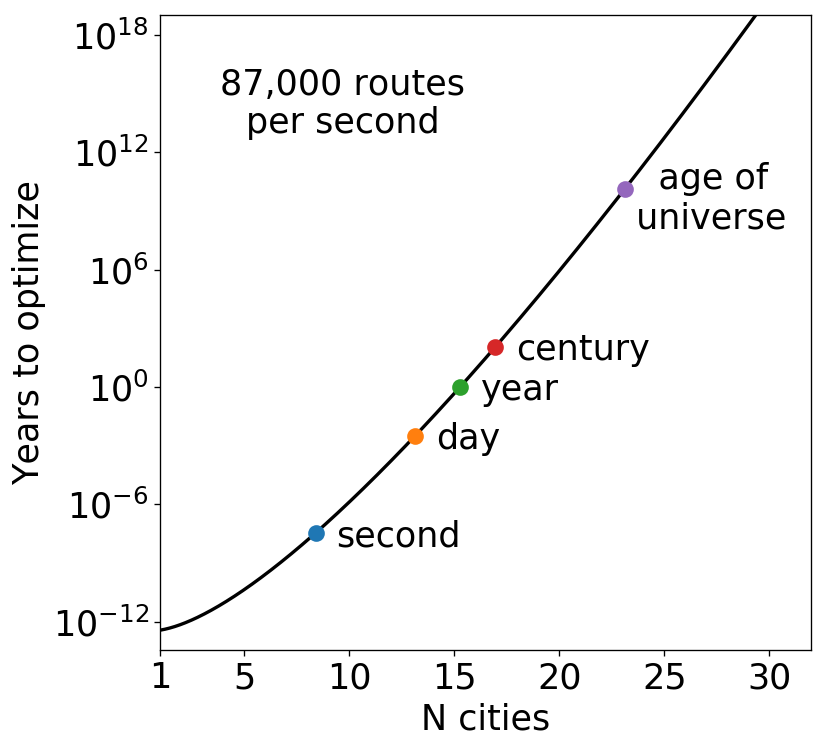

In [9]:
# constants
s_to_yr = 1/(3600*24*365) # convert seconds to years
cspeed = 1/87000 # seconds per computation

# calculate computational time
N = np.linspace(1,37,1000)
T = cspeed*factorial(N) *s_to_yr

# plot data
fig,ax = plt.subplots(1,1)
ax.plot(N,T,c='k',zorder=0)

# reference points
ref_times = dict()
ref_times['second'] = 1*s_to_yr
ref_times['day'] = 3600*24*s_to_yr
ref_times['year'] = 1
ref_times['century'] = 100
ref_times['   age of \n universe'] = 13.7e9
for name in ref_times:
    t = ref_times[name]
    X = 0
    Y = 0
    i = 0
    while Y < t:
        i += 1
        X = N[i]
        Y = T[i]
    ax.scatter(X,Y)
    xo = 1
    yo = 0.7
    if name == '   age of \n universe':
        xo = 0
        yo = 0.3
    ax.text(X+xo,yo*Y,name,va='center')

# labels
ax.set_xlabel('N cities')
ax.set_ylabel('Years to optimize')
ax.set_yscale('log')

ax.text(0.28,0.89,"87,000 routes",transform=ax.transAxes,ha='center',va='center')
ax.text(0.28,0.83,"per second",transform=ax.transAxes,ha='center',va='center')

ax.set_xlim(1,32)
ax.set_ylim(cspeed*s_to_yr/10,1e19)
ax.set_xticks([1,5,10,15,20,25,30])
ax.set_yticks([1e-12,1e-6,1,1e6,1e12,1e18])


fig.savefig("speed_mycomp.png")
plt.show()


This is insane! Even to find the perfect route through only 25 cities would take longer than the age of the universe! Maybe that is just because I have a weak computer. Let's create the same plot again, but assume I have a supercomputer than can check a billion routes per second:

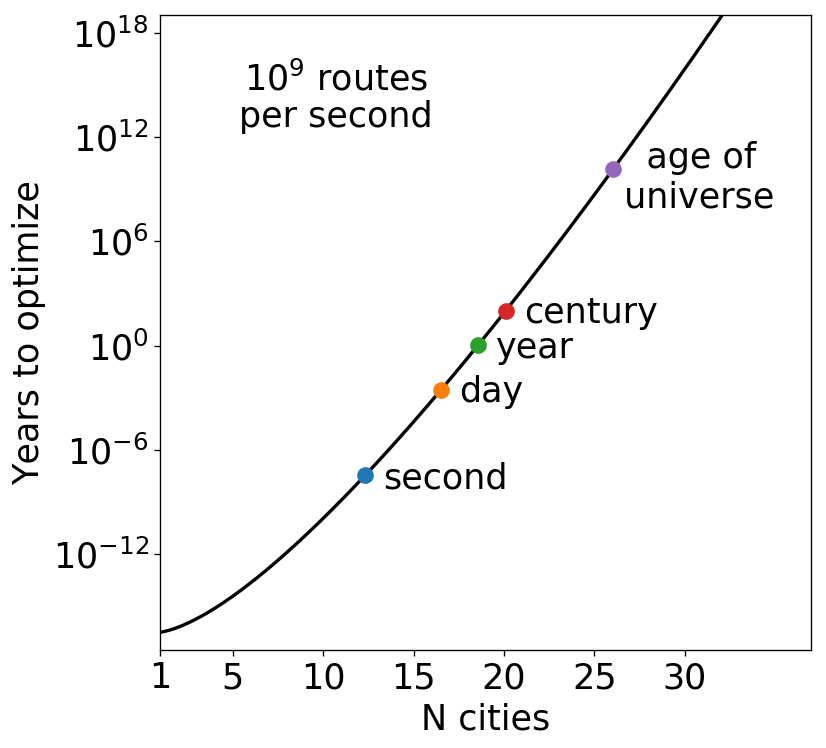

In [51]:
# constants
s_to_yr = 1/(3600*24*365) # convert seconds to years
cspeed = 1/1e9 # seconds per computation

# calculate computational time
N = np.linspace(1,37,1000)
T = cspeed*factorial(N) *s_to_yr

# plot data
fig,ax = plt.subplots(1,1)
ax.plot(N,T,c='k',zorder=0)

# reference points
ref_times = dict()
ref_times['second'] = 1*s_to_yr
ref_times['day'] = 3600*24*s_to_yr
ref_times['year'] = 1
ref_times['century'] = 100
ref_times['   age of \n universe'] = 13.7e9
for name in ref_times:
    t = ref_times[name]
    X = 0
    Y = 0
    i = 0
    while Y < t:
        i += 1
        X = N[i]
        Y = T[i]
    ax.scatter(X,Y)
    xo = 1
    yo = 0.7
    if name == '   age of \n universe':
        xo = 0
        yo = 0.3
    ax.text(X+xo,yo*Y,name,va='center')

# labels
ax.set_xlabel('N cities')
ax.set_ylabel('Years to optimize')
ax.set_yscale('log')

ax.text(0.27,0.90,"$10^9$ routes",transform=ax.transAxes,ha='center',va='center')
ax.text(0.27,0.84,"per second",transform=ax.transAxes,ha='center',va='center')

ax.set_xlim(1,37)
ax.set_ylim(cspeed*s_to_yr/10,1e19)
ax.set_xticks([1,5,10,15,20,25,30])
ax.set_yticks([1e-12,1e-6,1,1e6,1e12,1e18])


fig.savefig("speed_supercomp.png")
plt.show()


Now we can find the 25-city route within the age of the universe! But even with a supercomputer, this method is totally unfeasible. We will need to develop better methods to attack the problem.

### Approximate Solutions

Above we saw that brute force checking all of the possible routes, while exactly solving the problem, was too computationally expensive to be reasonable for more than a handful of cities. Unfortunately, there are no free lunches. Typically, if you want to solve the traveling salesman problem exactly, you must check all possible routes. However, this doesn't mean that the problem is totaly intractable! Rather than insisting on the exact solution, we can use other methods that attack the problem in interesting ways to generate approximate solutions. These methods aren't guaranteed to generate the exact solution, but will quickly generate routes that are close to the solutions (i.e. their total distances won't be too far from the shortest possible distance).

Below I will examine 2 methods for generating approximate solutions: simulated annealing and genetic algorithms. I will test them on this set of 30 US cities:

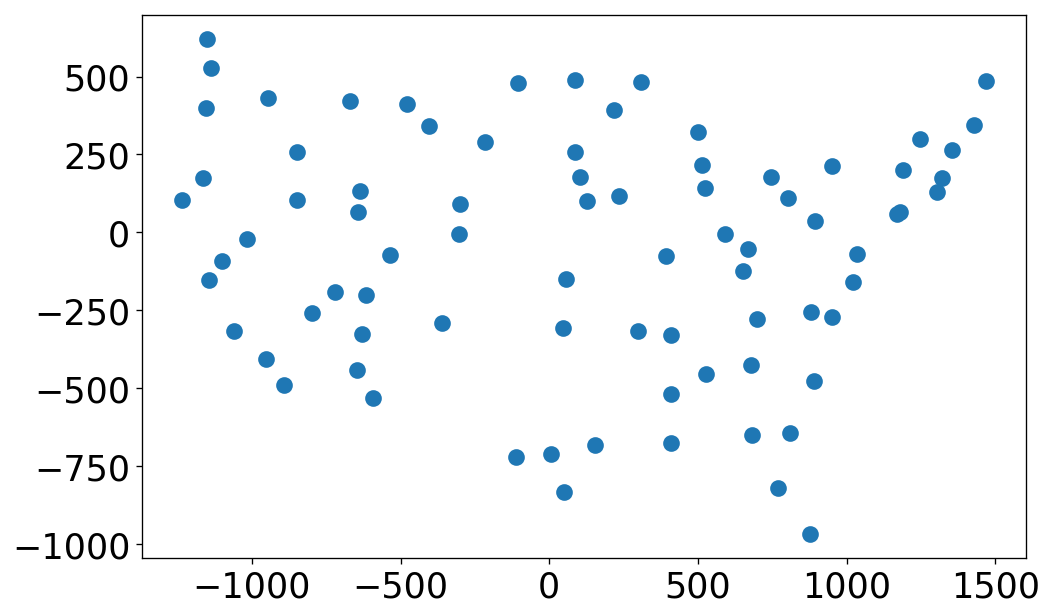

In [9]:
UScities = US_cities()
x = [i.x for i in UScities]
y = [i.y for i in UScities]
fig, ax = plt.subplots(1,1,figsize=(9.5,6))
ax.scatter(x,y)
fig.savefig("US_cities.png")

#### Approximate Solution 1: Simulated Annealing

Sources for simulated annealing:

https://www.fourmilab.ch/documents/travelling/anneal/

http://www.theprojectspot.com/tutorial-post/simulated-annealing-algorithm-for-beginners/6

Basically, I start with a random route. I mutate it and calculate the new distance. If it's smaller than the current one, I keep it. If it's bigger, I randomly keep it as a function of how much worse it is and the current temperature.

In [10]:
def mutate(route):
    """Mutates a route, but selecting a segment, and either 
    reversing it or inserting it into the other segment."""
    
    route = list(route)

    # determine segments to mutate
    i1,i2 = 0,0
    while i1 == i2:
        i1 = int(random.random()*len(route))
        i2 = int(random.random()*len(route))
    
    # if segment to mutate runs over end of array,
    # roll the array so that it doesn't
    if i1 > i2:
        route = np.array(route)
        shift = len(route)-i1
        route = np.roll(route,shift)
        route = [City(i) for i in route]
        i1 = 0
        i2 += shift
    
    # cut array into the 2 segments
    s1 = route[i1:i2]
    s2 = route.copy()
    del s2[i1:i2]
    
    mode = random.random() # determine mutation mode
    if mode >= 0.5:
        # reverse segment 1
        route = s1[::-1] + s2
    else:
        # insert seg. 1 into a random place in seg. 2
        i3 = int(random.random()*len(s2))
        route = s2[:i3] + s1 + s2[i3:]
        
    return Route(route)
    

In [11]:
def simulated_annealing(cities,T0=1e4,coolingRate=1e-3):
    """Minimizes the route distance through cities, 
    using simulated annealing"""
    
    # random starting point
    route = randomRoute(cities)
    
    # keep track of...
    # distances
    progress = [route.dist()]
    # temperatures
    temps = [T0]
    # the time
    start = time.time()
    times = [0]
    
    # main loop
    T = T0
    while T > 1:
        
        # mutate until we find a suitable mutation
        prob = 0
        rand = random.random()
        for i in range(100*len(cities)):
            route2 = mutate(route)
            prob = np.exp((route.dist()-route2.dist())/T)
            if prob > rand:
                break

        # if we never found one, break
        if prob < rand:
            break
            
        # else, save the data and continue
        else:
            # update the route
            route = route2
            
            # save...
            # route distance
            progress.append(route.dist())
            # the temperature
            temps.append(T)
            # the time
            now = time.time()
            times.append(now-start)
            
            # update the temp
            T *= 1-coolingRate

    return route,progress,temps,times

Now find the shortest route (approximately) for the US cities:

In [22]:
%%time
ANroute,ANprogress,ANtemps,ANtimes = simulated_annealing(UScities)

Wall time: 31.8 s


Plot the route length as a function of iteration:

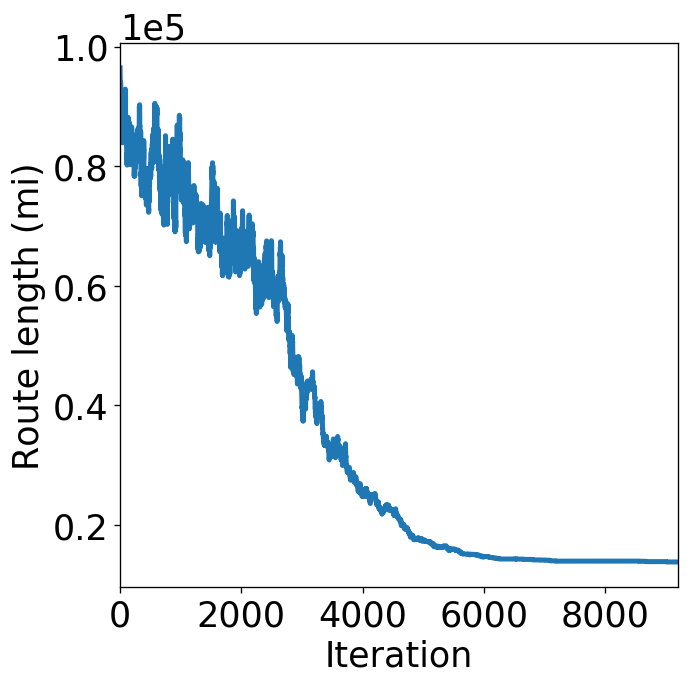

In [23]:
fig,ax = plt.subplots(1,1)
ax.plot(ANprogress)
ax.set_xlabel("Iteration")
ax.set_ylabel("Route length (mi)")
ax.ticklabel_format(axis='y',style='sci',scilimits=(-1,4))
ax.set_xlim(0,len(ANprogress))
plt.show()
fig.savefig("annealing.png")

Plot the route length as a function of temperature:

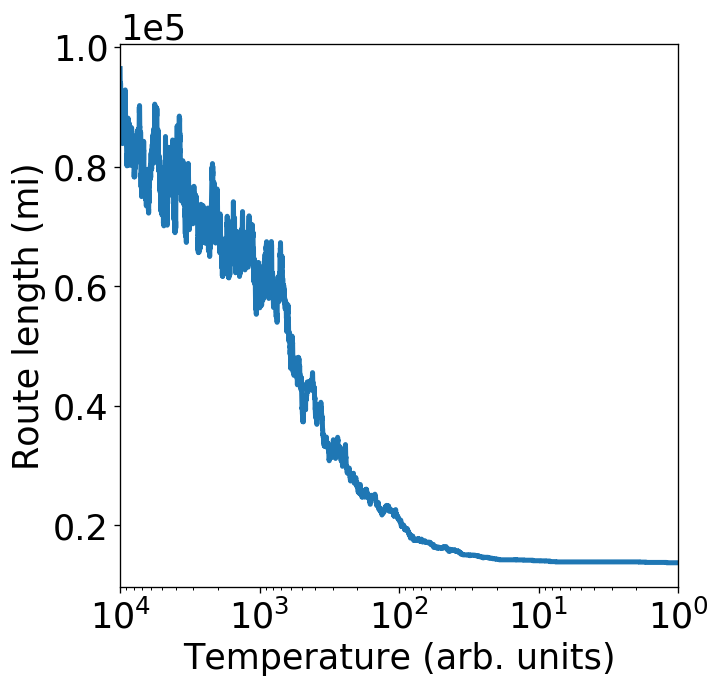

In [24]:
plt.plot(ANtemps,ANprogress)
plt.xscale('log')
plt.xlim(max(ANtemps),min(ANtemps))
plt.xlabel("Temperature (arb. units)")
plt.ylabel("Route length (mi)")
plt.ticklabel_format(axis='y',style='sci',scilimits=(-1,4))
plt.show()

Plot the best route length as a function of iteration:

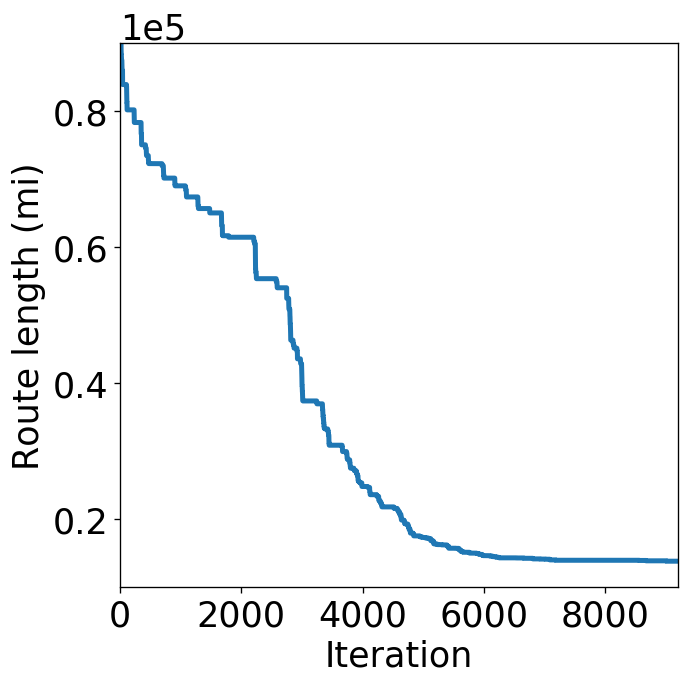

In [25]:
plt.plot(running_min(ANprogress))
plt.xlabel("Iteration")
plt.ylabel("Route length (mi)")
plt.ticklabel_format(axis='y',style='sci',scilimits=(-1,4))
plt.xlim(0,len(ANprogress))
plt.ylim(1e4,9e4)
plt.show()

Finally, plot the best route!

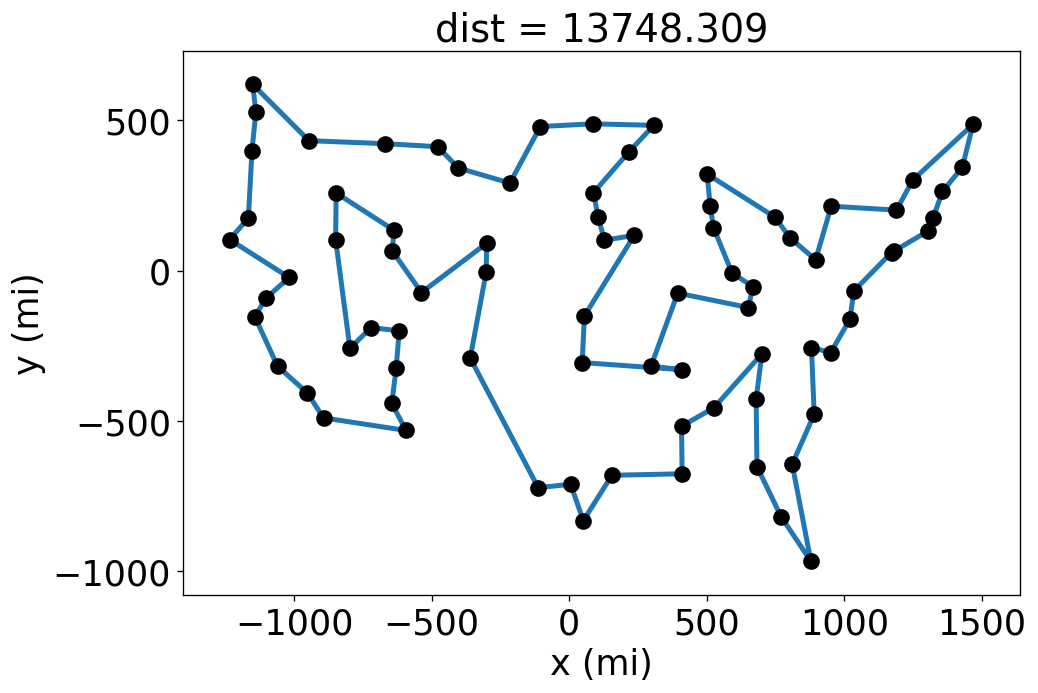

In [26]:
# plot the route
x = [city.x for city in ANroute]
y = [city.y for city in ANroute]
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.plot(x,y,c='C0')
ax.plot([x[0],x[-1]],[y[0],y[-1]],c='C0')
ax.scatter(x,y,c='k',zorder=10)
ax.set_xlabel("x (mi)")
ax.set_ylabel("y (mi)")
ax.set_title("dist = {0:.3f}".format(ANroute.dist()))
plt.show()
fig.savefig("annealing_solution.png")

This looks like a pretty good route. It might not be the best one, but I don't see any obvious changes to be made. Using the brute force method, this would've taken many orders of magnitude greater than the age of the universe!

#### Approximate Solution 2: Genetic Algorithm

The genetic algorithm takes inspiration from Darwinian evolution. You start with a population of many random routes. Then you select a mating pool. I let the shortest 5% of routes in, and for the rest, I randomly sample the routes with a probability dependent on their "fitness," which is the inverse of the distance. You then "breed" the routes, by randomly switching segments of each.

In [27]:
def createPopulation(cities,popSize):
    """Create a population of routes for a given set of cities."""
    population = [randomRoute(cities) for i in range(popSize)]
    return population

In [28]:
def matingPool(population,nElites):
    """Select the mating pool."""

    # rank population
    ranked = dict()
    for route in population:
        ranked[route] = route.fitness()
    ranked = sorted(ranked.items(), key = operator.itemgetter(1),
                    reverse = True)
    ranked = np.array(ranked)

    # calculate probabilities
    prob = ranked[:,1]/sum(ranked[:,1])
    # array of cumulative probabilities
    cumProb = [sum(prob[:i+1]) for i in range(len(prob))]

    # select mating pool
    # first be elitist and let the top group in
    matingpool = [ranked[i,0] for i in range(nElites)]
    while len(matingpool) < len(ranked):
        rand = random.random()
        for j,cp in enumerate(cumProb):
            if rand <= cp:
                route = ranked[j,0]
                matingpool.append(route)
                break

    return list(matingpool)

In [29]:
def breed(parent1, parent2):
    
    # arrays to hold swapped segment and the child "chromosome"
    swap = []
    child = []
    
    # beginning and end of swapped segment
    index1 = int(random.random() * len(parent1))
    index2 = int(random.random() * len(parent1))
    
    first = min(index1,index2)
    last  = max(index1,index2)
    
    # save the swapped segment
    for i in range(first,last):
        swap.append(parent1[i])
        
    # fill child up until the swap
    for i in parent2:
        if len(child) < first and i not in swap:
            child.append(i)
    
    # fill in the swap
    child += swap
    
    # fill in the rest
    for i in parent2:
        if i not in child:
            child.append(i)
            
    return Route(child)

In [30]:
def breedPopulation(matingpool, nElites):
    
    children = matingpool[:nElites]
    
    pool = random.sample(matingpool,len(matingpool))
    for i in range(len(pool)-nElites):
        parent1 = pool[i]
        parent2 = pool[len(pool)-i-1]
        children.append(breed(parent1,parent2))

    return children

In [31]:
def mutatePopulation(population, mutationRate, nElites):
    
    mutatedPopulation = population[:nElites]
    for route in population[nElites:]:
        if random.random() < mutationRate:
            route = mutate(route)
        mutatedPopulation.append(route)
    
    return mutatedPopulation

In [32]:
def mostFit(population):
    
    dist = [route.dist() for route in population]
    imin = np.argmin(dist)
    
    return population[imin], dist[imin]

In [33]:
def geneticAlgorithm(cities, popSize, nElites, mutationRate, 
                    generations):
    
    population = createPopulation(cities, popSize)
    
    route, dist = mostFit(population)
    progress = [dist]
    times = [0]
    
    start = time.time()
    for i in range(generations):
        matingpool = matingPool(population, nElites)
        children = breedPopulation(matingpool, nElites)
        population = mutatePopulation(children, mutationRate, nElites)
        route, dist = mostFit(population)
        progress.append(dist)
        now = time.time()
        times.append(now-start)
        
        if i % 100 == 0:
            print("Generation",i)
        
    return route, progress, times
    

In [34]:
%%time
GAroute,GAprogress,GAtimes = geneticAlgorithm(UScities,1000,200,0.001,500)

Generation 0
Generation 100
Generation 200
Generation 300
Generation 400
Wall time: 4min 25s


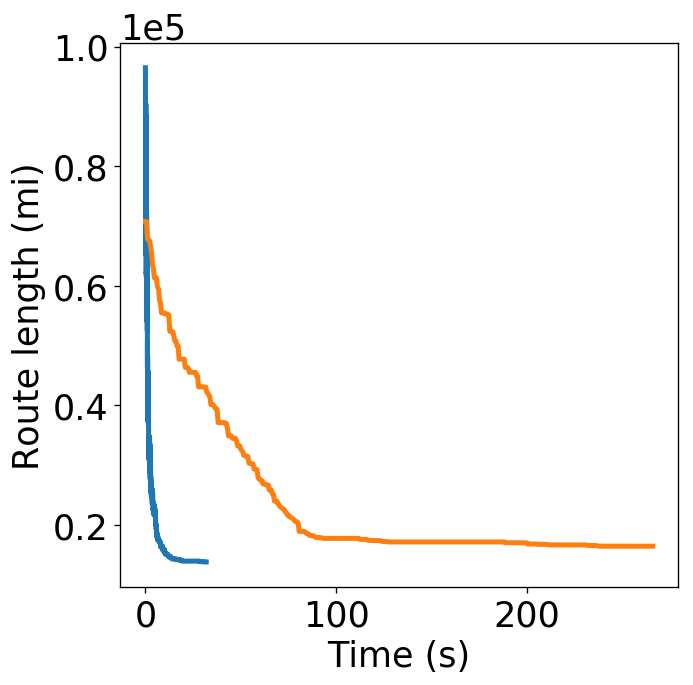

In [43]:
fig,ax = plt.subplots(1,1)
ax.plot(ANtimes,ANprogress)
ax.plot(GAtimes,GAprogress)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Route length (mi)")
plt.ticklabel_format(axis='y',style='sci',scilimits=(-1,4))
#plt.xlim(0,4)
plt.show()
fig.savefig("compare_progress.png")

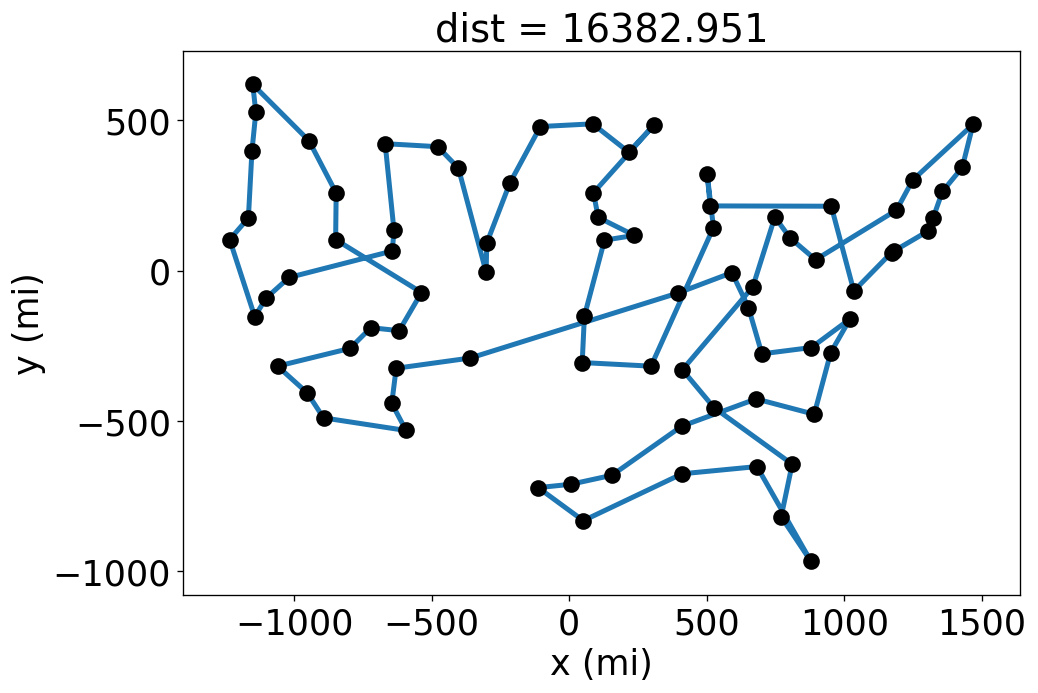

In [38]:
# plot the route
x = [city.x for city in GAroute]
y = [city.y for city in GAroute]
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.plot(x,y,c='C0')
ax.plot([x[0],x[-1]],[y[0],y[-1]],c='C0')
ax.scatter(x,y,c='k',zorder=10)
ax.set_xlabel("x (mi)")
ax.set_ylabel("y (mi)")
ax.set_title("dist = {0:.3f}".format(GAroute.dist()))
plt.show()
fig.savefig("genetic_solution.png")